In [ ]:
# !pip install matplotlib seaborn

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from matplotlib import font_manager, rc

In [2]:
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [3]:
# 데이터 로드
DATA_PATH = "../data/"
train = pd.read_csv(DATA_PATH + 'train.csv')
dev = pd.read_csv(DATA_PATH + 'dev.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')

In [4]:
print("="*80)
print("📊 대화 요약 데이터 텍스트 인사이트 분석")
print("="*80)

📊 대화 요약 데이터 텍스트 인사이트 분석


In [5]:
# ========================================
# 1. 기본 통계 분석
# ========================================
print("\n\n### 1️⃣ 기본 통계 분석 ###\n")

# 1-1. 데이터셋 크기
print(f"📌 Train 데이터: {len(train):,}개")
print(f"📌 Dev 데이터: {len(dev):,}개")
print(f"📌 Test 데이터: {len(test):,}개")




### 1️⃣ 기본 통계 분석 ###

📌 Train 데이터: 12,457개
📌 Dev 데이터: 499개
📌 Test 데이터: 499개


In [6]:
# 1-2. 대화 길이 분석 (문자 수)
train['dialogue_length'] = train['dialogue'].apply(lambda x: len(str(x)))
train['summary_length'] = train['summary'].apply(lambda x: len(str(x)))
train['compression_ratio'] = train['summary_length'] / train['dialogue_length']

print("\n📊 대화 길이 통계 (문자 수):")
print(train['dialogue_length'].describe())

print("\n📊 요약문 길이 통계 (문자 수):")
print(train['summary_length'].describe())

print("\n📊 압축률 통계 (요약/대화):")
print(train['compression_ratio'].describe())
print(f"평균 압축률: {train['compression_ratio'].mean():.2%}")



📊 대화 길이 통계 (문자 수):
count    12457.000000
mean       406.083487
std        197.566083
min         84.000000
25%        280.000000
50%        369.000000
75%        500.000000
max       2165.000000
Name: dialogue_length, dtype: float64

📊 요약문 길이 통계 (문자 수):
count    12457.000000
mean        85.789436
std         33.811948
min         13.000000
25%         61.000000
50%         80.000000
75%        104.000000
max        376.000000
Name: summary_length, dtype: float64

📊 압축률 통계 (요약/대화):
count    12457.000000
mean         0.232274
std          0.086031
min          0.050388
25%          0.175202
50%          0.217021
75%          0.270042
max          0.990099
Name: compression_ratio, dtype: float64
평균 압축률: 23.23%


In [7]:
# 1-3. 토큰 수 기준 길이 (공백 기준)
train['dialogue_tokens'] = train['dialogue'].apply(lambda x: len(str(x).split()))
train['summary_tokens'] = train['summary'].apply(lambda x: len(str(x).split()))

print("\n📊 대화 토큰 수 통계:")
print(train['dialogue_tokens'].describe())

print("\n📊 요약문 토큰 수 통계:")
print(train['summary_tokens'].describe())



📊 대화 토큰 수 통계:
count    12457.000000
mean        84.464478
std         43.613074
min         17.000000
25%         56.000000
50%         75.000000
75%        106.000000
max        508.000000
Name: dialogue_tokens, dtype: float64

📊 요약문 토큰 수 통계:
count    12457.000000
mean        16.480694
std          7.015613
min          4.000000
25%         11.000000
50%         15.000000
75%         20.000000
max         75.000000
Name: summary_tokens, dtype: float64


In [8]:
# ========================================
# 2. 화자 분석
# ========================================
print("\n\n### 2️⃣ 화자 분석 ###\n")

def count_speakers(dialogue):
    """대화에 등장하는 화자 수 계산"""
    if pd.isna(dialogue):
        return 0
    speakers = re.findall(r'#Person(\d+)#', str(dialogue))
    return len(set(speakers))

def count_turns(dialogue):
    """대화 턴 수 계산"""
    if pd.isna(dialogue):
        return 0
    # \n으로 구분된 턴 수
    turns = str(dialogue).split('\n')
    return len([t for t in turns if t.strip()])

train['num_speakers'] = train['dialogue'].apply(count_speakers)
train['num_turns'] = train['dialogue'].apply(count_turns)




### 2️⃣ 화자 분석 ###



In [9]:
print("📊 화자 수 분포:")
print(train['num_speakers'].value_counts().sort_index())

print("\n📊 평균 화자 수:", train['num_speakers'].mean())
print("📊 최대 화자 수:", train['num_speakers'].max())

print("\n📊 대화 턴 수 통계:")
print(train['num_turns'].describe())


📊 화자 수 분포:
num_speakers
2    12335
3      107
4       10
5        3
6        1
7        1
Name: count, dtype: int64

📊 평균 화자 수: 2.011640041743598
📊 최대 화자 수: 7

📊 대화 턴 수 통계:
count    12457.000000
mean         9.478526
std          4.150184
min          1.000000
25%          7.000000
50%          9.000000
75%         12.000000
max         59.000000
Name: num_turns, dtype: float64


In [10]:
# 화자별 평균 대화 길이
print("\n📊 화자 수별 평균 대화 길이:")
speaker_dialogue_length = train.groupby('num_speakers')['dialogue_length'].agg(['mean', 'count'])
print(speaker_dialogue_length)


📊 화자 수별 평균 대화 길이:
                     mean  count
num_speakers                    
2              404.239400  12335
3              556.317757    107
4              586.700000     10
5             1472.333333      3
6             1125.000000      1
7             1354.000000      1


In [11]:
# ========================================
# 3. 특수 토큰 분석
# ========================================
print("\n\n### 3️⃣ 특수 토큰 분석 ###\n")

special_tokens = ['#Person1#', '#Person2#', '#Person3#', '#Person4#', 
                  '#Person5#', '#Person6#', '#Person7#',
                  '#PhoneNumber#', '#Address#', '#PassportNumber#']

print("📊 특수 토큰 출현 빈도:")
for token in special_tokens:
    count = train['dialogue'].str.contains(token, regex=False).sum()
    if count > 0:
        print(f"  {token}: {count:,}회 ({count/len(train)*100:.2f}%)")




### 3️⃣ 특수 토큰 분석 ###

📊 특수 토큰 출현 빈도:
  #Person1#: 12,457회 (100.00%)
  #Person2#: 12,457회 (100.00%)
  #Person3#: 122회 (0.98%)
  #Person4#: 15회 (0.12%)
  #Person5#: 5회 (0.04%)
  #Person6#: 2회 (0.02%)
  #Person7#: 1회 (0.01%)
  #PhoneNumber#: 151회 (1.21%)
  #Address#: 81회 (0.65%)
  #PassportNumber#: 5회 (0.04%)


In [12]:
# ========================================
# 4. 노이즈 패턴 분석
# ========================================
print("\n\n### 4️⃣ 노이즈 패턴 분석 ###\n")

# \\n 패턴 (잘못된 개행)
noise_patterns = {
    '\\\\n 패턴': r'\\\\n',
    '<br> 태그': r'<br\s*/?>', 
    '다중 공백': r'\s{3,}',
    '특수문자 연속': r'[^\w\s가-힣]{3,}'
}

print("📊 노이즈 패턴 출현 빈도:")
for name, pattern in noise_patterns.items():
    count = train['dialogue'].str.contains(pattern, regex=True).sum()
    print(f"  {name}: {count:,}개 ({count/len(train)*100:.2f}%)")



### 4️⃣ 노이즈 패턴 분석 ###

📊 노이즈 패턴 출현 빈도:
  \\n 패턴: 0개 (0.00%)
  <br> 태그: 1개 (0.01%)
  다중 공백: 24개 (0.19%)
  특수문자 연속: 1,263개 (10.14%)


In [13]:
# ========================================
# 5. 주제 분석 (dev 데이터)
# ========================================
if 'topic' in dev.columns:
    print("\n\n### 5️⃣ 주제 분석 (Dev 데이터) ###\n")
    
    print("📊 주제별 분포:")
    topic_counts = dev['topic'].value_counts()
    print(topic_counts)
    
    # 주제별 평균 길이
    dev['dialogue_length'] = dev['dialogue'].apply(lambda x: len(str(x)))
    print("\n📊 주제별 평균 대화 길이:")
    print(dev.groupby('topic')['dialogue_length'].mean().sort_values(ascending=False))



### 5️⃣ 주제 분석 (Dev 데이터) ###

📊 주제별 분포:
topic
호텔 방 예약     5
길 안내        4
취업 면접       4
음식 주문       4
신발 구매       2
           ..
음악 활동       1
나노미터 설명     1
감사 전화       1
옷 쇼핑과 교환    1
여름방학 일자리    1
Name: count, Length: 475, dtype: int64

📊 주제별 평균 대화 길이:
topic
결혼 계획               1269.0
쇼핑 영수증 문제           1269.0
금요일 저녁 계획           1071.0
이혼과 아이들에게 미치는 영향    1069.0
처방전 재발급 요청          1046.0
                     ...  
기분 저하                128.0
피카소 전시회              127.0
수업 지각 문제             117.0
식료품점에서의 우연한 만남       115.0
손 부상과 조언             114.0
Name: dialogue_length, Length: 475, dtype: float64


In [14]:
# ========================================
# 6. 첫 턴 분석
# ========================================
print("\n\n### 6️⃣ 첫 턴 분석 ###\n")

def get_first_turn(dialogue):
    """첫 번째 턴 추출"""
    if pd.isna(dialogue):
        return ""
    turns = str(dialogue).split('\n')
    return turns[0] if turns else ""

train['first_turn'] = train['dialogue'].apply(get_first_turn)
train['first_turn_length'] = train['first_turn'].apply(len)

print("📊 첫 턴 길이 통계:")
print(train['first_turn_length'].describe())



### 6️⃣ 첫 턴 분석 ###

📊 첫 턴 길이 통계:
count    12457.000000
mean        39.068154
std         22.404312
min         14.000000
25%         27.000000
50%         34.000000
75%         45.000000
max        706.000000
Name: first_turn_length, dtype: float64


In [15]:
# 첫 턴에 자주 등장하는 패턴
first_turn_keywords = []
for turn in train['first_turn'].head(100):
    # 인사말이나 질문 패턴 찾기
    if '안녕' in turn:
        first_turn_keywords.append('인사')
    if '?' in turn:
        first_turn_keywords.append('질문')
    if '찾' in turn or '원하' in turn:
        first_turn_keywords.append('요청')

print("\n📊 첫 턴 패턴 (샘플 100개 기준):")
keyword_counter = Counter(first_turn_keywords)
for keyword, count in keyword_counter.most_common():
    print(f"  {keyword}: {count}회")


📊 첫 턴 패턴 (샘플 100개 기준):
  질문: 66회
  인사: 19회
  요청: 1회


In [16]:
# ========================================
# 7. 요약 스타일 분석
# ========================================
print("\n\n### 7️⃣ 요약 스타일 분석 ###\n")

# 요약문에 대화 내용이 직접 포함되었는지 (추출적 요약 vs 추상적 요약)
def check_extractive(row):
    """추출적 요약 여부 확인 (대화의 일부가 요약에 그대로 있는지)"""
    dialogue = str(row['dialogue']).replace('#Person1#', '').replace('#Person2#', '')
    summary = str(row['summary'])
    
    # 3단어 이상의 연속된 구문이 있는지 확인
    dialogue_words = dialogue.split()
    summary_words = summary.split()
    
    for i in range(len(summary_words) - 2):
        phrase = ' '.join(summary_words[i:i+3])
        if phrase in dialogue:
            return True
    return False

# 샘플 1000개로 확인 (전체는 시간이 오래 걸림)
sample = train.sample(min(1000, len(train)), random_state=42)
sample['is_extractive'] = sample.apply(check_extractive, axis=1)




### 7️⃣ 요약 스타일 분석 ###



In [17]:
extractive_ratio = sample['is_extractive'].sum() / len(sample)
print(f"📊 추출적 요약 비율 (샘플 기준): {extractive_ratio:.2%}")
print(f"📊 추상적 요약 비율 (샘플 기준): {1-extractive_ratio:.2%}")

📊 추출적 요약 비율 (샘플 기준): 22.40%
📊 추상적 요약 비율 (샘플 기준): 77.60%




### 8️⃣ Visualization.. ###



Text(0, 0.5, 'avg of dialogue_length')

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

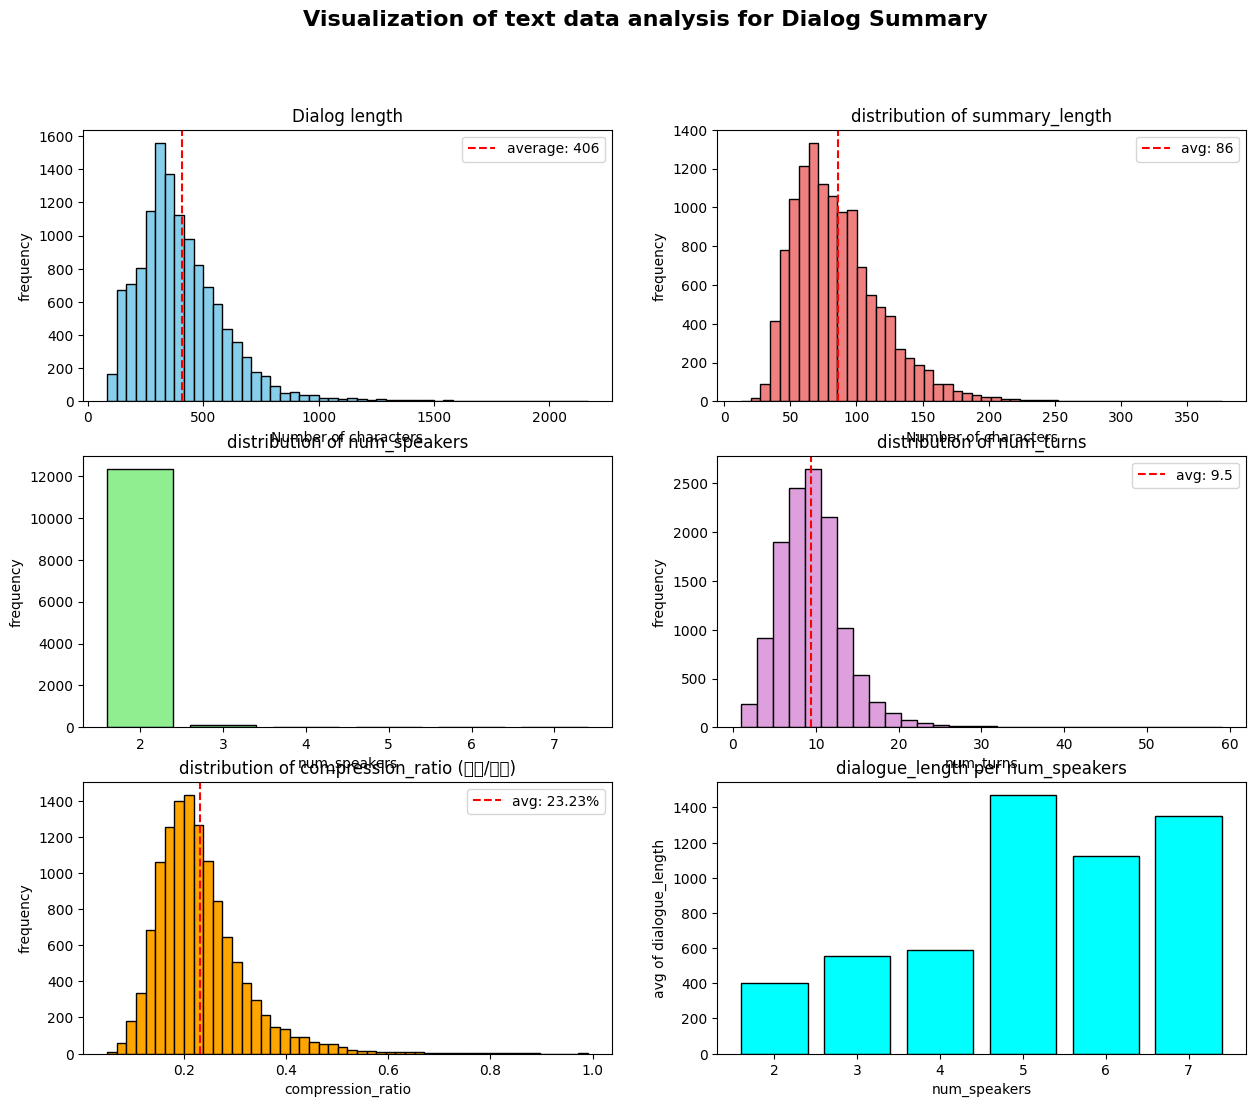

In [26]:
# ========================================
# 8. 시각화
# ========================================
print("\n\n### 8️⃣ Visualization.. ###\n") #시각화 생성 중.

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Visualization of text data analysis for Dialog Summary', fontsize=16, fontweight='bold') #대화 요약 데이터 텍스트 분석 시각화

# 1. 대화 길이 분포
axes[0, 0].hist(train['dialogue_length'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Dialog length') #대화 길이 분포
axes[0, 0].set_xlabel('Number of characters') #문자 수
axes[0, 0].set_ylabel('frequency') #빈도
axes[0, 0].axvline(train['dialogue_length'].mean(), color='red', linestyle='--', 
                   label=f'average: {train["dialogue_length"].mean():.0f}') #평균
axes[0, 0].legend()

# 2. 요약문 길이 분포
axes[0, 1].hist(train['summary_length'], bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('distribution of summary_length') #요약문 길이 분포
axes[0, 1].set_xlabel('Number of characters')
axes[0, 1].set_ylabel('frequency')
axes[0, 1].axvline(train['summary_length'].mean(), color='red', linestyle='--',
                   label=f'avg: {train["summary_length"].mean():.0f}')
axes[0, 1].legend()

# 3. 화자 수 분포
speaker_counts = train['num_speakers'].value_counts().sort_index()
axes[1, 0].bar(speaker_counts.index, speaker_counts.values, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('distribution of num_speakers')
axes[1, 0].set_xlabel('num_speakers')
axes[1, 0].set_ylabel('frequency')

# 4. 턴 수 분포
axes[1, 1].hist(train['num_turns'], bins=30, color='plum', edgecolor='black')
axes[1, 1].set_title('distribution of num_turns')
axes[1, 1].set_xlabel('num_turns')
axes[1, 1].set_ylabel('frequency')
axes[1, 1].axvline(train['num_turns'].mean(), color='red', linestyle='--',
                   label=f'avg: {train["num_turns"].mean():.1f}')
axes[1, 1].legend()

# 5. 압축률 분포
axes[2, 0].hist(train['compression_ratio'], bins=50, color='orange', edgecolor='black')
axes[2, 0].set_title('distribution of compression_ratio (요약/대화)')
axes[2, 0].set_xlabel('compression_ratio')
axes[2, 0].set_ylabel('frequency')
axes[2, 0].axvline(train['compression_ratio'].mean(), color='red', linestyle='--',
                   label=f'avg: {train["compression_ratio"].mean():.2%}')
axes[2, 0].legend()

# 6. 화자 수별 평균 대화 길이
speaker_avg = train.groupby('num_speakers')['dialogue_length'].mean()
axes[2, 1].bar(speaker_avg.index, speaker_avg.values, color='cyan', edgecolor='black')
axes[2, 1].set_title('dialogue_length per num_speakers') #화자 수별 평균 대화 길이
axes[2, 1].set_xlabel('num_speakers')
axes[2, 1].set_ylabel('avg of dialogue_length') #평균 문자 수

In [27]:
plt.tight_layout()
plt.savefig('dialogue_analysis_visualization.png', dpi=300, bbox_inches='tight')
print("✅ 시각화 저장 완료: dialogue_analysis_visualization.png")

✅ 시각화 저장 완료: dialogue_analysis_visualization.png


<Figure size 640x480 with 0 Axes>

In [28]:
# ========================================
# 9. 주요 인사이트 요약
# ========================================
print("\n\n" + "="*80)
print("🎯 주요 인사이트 요약")
print("="*80)

print(f"""
1️⃣ 데이터 규모
   - 총 {len(train):,}개의 훈련 대화
   - 평균 대화 길이: {train['dialogue_length'].mean():.0f}자
   - 평균 요약 길이: {train['summary_length'].mean():.0f}자

2️⃣ 압축 특성
   - 평균 압축률: {train['compression_ratio'].mean():.2%}
   - 대화가 평균 {1/train['compression_ratio'].mean():.1f}배로 압축됨
   
3️⃣ 화자 구성
   - 평균 화자 수: {train['num_speakers'].mean():.1f}명
   - 가장 흔한 화자 수: {train['num_speakers'].mode()[0]}명
   - 평균 대화 턴: {train['num_turns'].mean():.1f}턴

4️⃣ 모델링 권장사항
   - Encoder max_length: {int(train['dialogue_length'].quantile(0.95))} (95 percentile)
   - Decoder max_length: {int(train['summary_length'].quantile(0.95))} (95 percentile)
   - 다양한 화자 수를 처리할 수 있는 모델 필요
   
5️⃣ 데이터 품질
   - 노이즈 패턴이 존재하므로 전처리 필요
   - 특수 토큰 정규화 필요
""")

print("="*80)
print("✅ 분석 완료!")
print("="*80)



🎯 주요 인사이트 요약

1️⃣ 데이터 규모
   - 총 12,457개의 훈련 대화
   - 평균 대화 길이: 406자
   - 평균 요약 길이: 86자

2️⃣ 압축 특성
   - 평균 압축률: 23.23%
   - 대화가 평균 4.3배로 압축됨
   
3️⃣ 화자 구성
   - 평균 화자 수: 2.0명
   - 가장 흔한 화자 수: 2명
   - 평균 대화 턴: 9.5턴

4️⃣ 모델링 권장사항
   - Encoder max_length: 742 (95 percentile)
   - Decoder max_length: 149 (95 percentile)
   - 다양한 화자 수를 처리할 수 있는 모델 필요
   
5️⃣ 데이터 품질
   - 노이즈 패턴이 존재하므로 전처리 필요
   - 특수 토큰 정규화 필요

✅ 분석 완료!
